首先 import 必要的模块

In [2]:
#from xgboost import XGBClassifier
import lightgbm as lgbm
#from lgbm.sklearn import LGBMClassifier

import pandas as pd 
import numpy as np
import time

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss     #采用logloss作为评价指标

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据

In [114]:
train = pd.read_csv("D:/Jupyter/w000/train_final/800w/800_0",index_col=0)   #拿200万条数据训练
train.drop(['id','hour','user_id','Unnamed: 0'],axis=1,inplace=True)
train.shape

(7932959, 23)

In [115]:
valid = pd.read_csv("D:/Jupyter/w000/train_final/400w/400_1",index_col=0)   #拿200万条数据训练
valid.drop(['id','hour','user_id','Unnamed: 0'],axis=1,inplace=True)
valid.shape

(3936502, 23)

In [116]:
test = pd.read_csv("D:/Jupyter/w000/train_final/FE_test_26_final.csv",index_col=0)   #拿200万条数据训练
test.drop(['id','hour','user_id'],axis=1,inplace=True)
test.head()

C:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,...,C15,C16,C17,C18,C19,C20,C21,hour_hours,hour_weekday,hour_days
36210029,0,0,1,86,2,1,0,0,0,140,...,0,0,181,0,0,53,11,0,4,9
36210030,0,0,1,86,2,1,0,0,0,7,...,0,0,181,0,0,34,11,0,4,9
36210031,0,0,0,128,109,3,0,0,0,53,...,0,0,27,1,1,2,0,0,4,9
36210032,0,0,1,5,5,1,0,0,0,98,...,0,0,2,0,10,0,3,0,4,9
36210033,0,0,0,59,58,1,0,0,0,111,...,0,0,35,1,4,0,0,0,4,9


## Variable Identification

选择该数据集是因为的数据特征单一，我们可以在特征工程方面少做些工作，集中精力放在参数调优上

In [117]:
y_train = train['click']
X_train = train.drop(["click"], axis=1)

y_valid = valid['click']
X_valid = valid.drop(["click"], axis=1)

y_test = test['click']
X_test = test.drop(["click"], axis=1)

默认参数，此时学习率为0.1，比较大，观察弱分类数目的大致范围
（采用默认参数配置，看看模型是过拟合还是欠拟合）

In [8]:
#直接调用LightGBM内嵌的交叉验证（cv），可对连续的n_estimators参数进行快速交叉验证
#而GridSearchCV只能对有限个参数进行交叉验证
import json
def modelfit(params, alg, X_train, y_train,early_stopping_rounds=50):
    lgbm_params = params.copy()
    
    lgbmtrain = lgbm.Dataset(X_train, y_train, silent=True,categorical_feature=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])

    
    cv_result = lgbm.cv(
        lgbm_params, lgbmtrain, num_boost_round=10000, nfold=3, stratified=False, shuffle=True, metrics='binary_logloss',
        early_stopping_rounds=early_stopping_rounds,show_stdv=True,seed=0)
    # note: cv_results will look like: {"multi_logloss-mean": <a list of historical mean>,
    # "multi_logloss-stdv": <a list of historical standard deviation>}
    print('best n_estimators:', len(cv_result['binary_logloss-mean']))
    print('best cv logloss:', cv_result['binary_logloss-mean'][-1])
    #cv_result.to_csv('lgbm1_nestimators.csv', index_label = 'n_estimators')
    json.dump(cv_result, open('lgbm_1.json', 'w'))
    #
    
    # 采用交叉验证得到的最佳参数n_estimators，训练模型
    alg.set_params(n_estimators = len(cv_result['binary_logloss-mean']))
    alg.fit(X_train, y_train)

    y_pred_train = alg.predict_proba(X_train)
    logloss = log_loss(y_train, y_pred_train)
    print ("logloss of train :",logloss )
    
    y_pred_test = alg.predict_proba(X_test)
    logloss = log_loss(y_test, y_pred_test)
    print ("logloss of test :",logloss )


In [9]:
params = {'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'nthread': 6, 
          #default=OpenMP_default, type=int, alias=num_thread, nthread LightGBM 的线程数
          'silent': True,
          'learning_rate': 0.1, 
          'num_leaves': 50, 
          #num_leaves：叶子数
#num_leaves, default=31, type=int, alias=num_leaf一棵树上的叶子数
          'max_depth': 6,
          'max_bin': 256, 
          'subsample_for_bin': 200000,#默认200000，用来构建直方图数据数量
          'subsample': 0.8, #默认1
          #类似于feature_fraction,它将在不进行重采样的情况下
          #随机选择部分数据可以用来加速训练可以用来处理过拟合Not
          'subsample_freq': 1, 
          'colsample_bytree': 0.8,       
          'reg_alpha': 0,         
          'reg_lambda': 0, 
          'min_split_gain': 0.0, 
          'min_child_weight': 1,        
          'min_child_samples': 100, 
          'min_data_in_leaf':2000, 
          #default=20, type=int, alias=min_data_per_leaf , min_data, 
          #min_child_samples一个叶子上数据的最小数量. 可以用来处理过拟合.
        

         }

In [10]:
time_start=time.time()

lgbm1 = lgbm.sklearn.LGBMClassifier(n_estimators=1000,seed=0, **params)
modelfit(params,lgbm1, X_train, y_train)

time_end=time.time()
a=time_end - time_start
print('time cost'+str(a)+'s')


C:\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Anaconda3\lib\site-packages\lightgbm\basic.py:661: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


best n_estimators: 363
best cv logloss: 0.3998200300886134
logloss of train : 0.40013086259651365
logloss of test : 0.4039739125311909
time cost255.63825130462646s


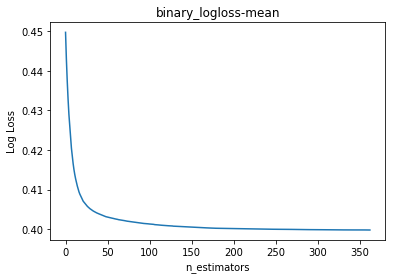

In [11]:
### cv_result = pd.DataFrame.from_csv('lgbm1_nestimators.csv')
cv_result = pd.read_json("lgbm_1.json")

# plot
test_means = cv_result['binary_logloss-mean']
#train_means = cvresult['train-logloss-mean']

x_axis = range(0, cv_result.shape[0])
pyplot.plot(x_axis, test_means) 
pyplot.title("binary_logloss-mean")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'lgbm1_n_estimators.png')
pyplot.show()

### 2、调整树的层数和叶子节点个数

In [12]:
num_leaves=[50,60,80]
max_depth=[6,7,8]
param_test2_1=dict(num_leaves=num_leaves,max_depth=max_depth)
param_test2_1

{'max_depth': [6, 7, 8], 'num_leaves': [50, 60, 80]}

In [13]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=3)

params = {'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'nthread': 6, 
          'silent': True,
          'learning_rate': 0.1, 
          'num_leaves': 50, 
          'max_depth': 6,
          'max_bin': 363, 
          'subsample_for_bin': 200000,#默认200000，用来构建直方图数据数量
          'subsample': 0.8, #默认1
          'subsample_freq': 1, 
          'colsample_bytree': 0.8, 
          'reg_alpha': 0,          
          'reg_lambda': 0,  
          'min_split_gain': 0.0, 
          'min_child_weight': 1,         
          'min_child_samples': 100, 
          'scale_pos_weight': 1,
         }
lgbm2_1=lgbm.sklearn.LGBMClassifier(n_estimators=365,seed=0,**params)
gsearch2_1=GridSearchCV(lgbm2_1,param_grid=param_test2_1,scoring='neg_log_loss',n_jobs=3, cv=kfold)


gsearch2_1.fit(X_train,y_train,categorical_feature=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])


C:\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        learning_rate=0.1, max_bin=363, max_depth=6, min_child_samples=100,
        min_child_weight=1, min_split_gain=0.0, n_estimators=365,
        n_jobs=-1, nthread=6, num_leaves=50, objective='binary',
        random_state=None, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
        seed=0, silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=1),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'num_leaves': [50, 60, 80], 'max_depth': [6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [14]:
print(gsearch2_1.cv_results_)
print(gsearch2_1.best_score_)

y_pred_train = gsearch2_1.predict_proba(X_train)
logloss = log_loss(y_train, y_pred_train)
print ("logloss of train :",logloss )

y_pred_test = gsearch2_1.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_test)
print ("logloss of test :",logloss )

{'mean_fit_time': array([103.00007288, 132.42437975, 153.99344206, 169.69558167,
       172.11771496, 178.8448449 , 177.08994706, 183.67917387,
       168.77629352]), 'std_fit_time': array([ 9.30479354, 26.23411794,  3.40672296,  6.32590884,  2.92489557,
        3.35738066,  2.24613149,  4.87940454, 18.83478456]), 'mean_score_time': array([21.64225586, 13.17840155, 12.71249477, 14.30360476, 13.93203108,
       14.34414442, 14.22060712, 14.85142008, 18.7050755 ]), 'std_score_time': array([6.85382836, 0.66749651, 0.13430911, 0.67895085, 0.47263521,
       0.3245092 , 0.25607761, 0.31643679, 4.82394103]), 'param_max_depth': masked_array(data=[6, 6, 6, 7, 7, 7, 8, 8, 8],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_num_leaves': masked_array(data=[50, 60, 80, 50, 60, 80, 50, 60, 80],
             mask=[False, False, False, False, False, False, False, False,
                   Fa

Best: -0.399487 using {'max_depth': 8, 'num_leaves': 50}


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessin

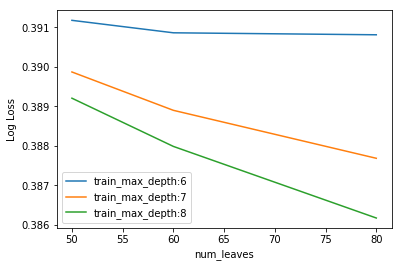

In [81]:
# summarize results
print("Best: %f using %s" % (gsearch2_1.best_score_, gsearch2_1.best_params_))
test_means = gsearch2_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch2_1.cv_results_[ 'std_test_score' ]
train_means = gsearch2_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch2_1.cv_results_[ 'std_train_score' ]


pd.DataFrame(gsearch2_1.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(max_depth), len(num_leaves))
train_scores = np.array(train_means).reshape(len(max_depth), len(num_leaves))

for i, value in enumerate(max_depth):
#    pyplot.plot(num_leaves, -test_scores[i], label= 'valid_max_depth:'   + str(value))
    pyplot.plot(num_leaves, -train_scores[i], label= 'train_max_depth:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'num_leaves' )                                                                                                      
pyplot.ylabel( 'Log Loss' )
pyplot.savefig('max_depth_vs_min_child_weght_1.png' )

### 3、调整叶子节点数目正则系数和叶子节点分数正则系数

In [32]:
reg_alpha=[0.4,0.6,0.8]
reg_lambda=[0.2,0.25,0.3]
param_2=dict(reg_alpha=reg_alpha,reg_lambda=reg_lambda)
param_2

{'reg_alpha': [0.4, 0.6, 0.8], 'reg_lambda': [0.2, 0.25, 0.3]}

In [33]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=3)

params = {'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'nthread': 6, 
          'silent': True,
          'learning_rate': 0.1, 
          'num_leaves': 50, 
          'max_depth': 8,
          'max_bin': 256, 
          'subsample_for_bin': 200000,#默认200000，用来构建直方图数据数量
          'subsample': 0.8, #默认1
          'subsample_freq': 1, 
          'colsample_bytree': 0.8, 
          'reg_alpha': 0,          
          'reg_lambda': 0,  
          'min_split_gain': 0.0, 
          'min_child_weight': 1,         
          'min_child_samples': 20, 
          'scale_pos_weight': 1,
         }
lgbm_2=lgbm.sklearn.LGBMClassifier(n_estimators=363,seed=0,**params)
gsearch2_2=GridSearchCV(lgbm_2,param_grid=param_2,scoring='neg_log_loss',n_jobs=6, cv=kfold)
gsearch2_2.fit(X_train,y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        learning_rate=0.1, max_bin=256, max_depth=8, min_child_samples=20,
        min_child_weight=1, min_split_gain=0.0, n_estimators=363,
        n_jobs=-1, nthread=6, num_leaves=50, objective='binary',
        random_state=None, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
        seed=0, silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=1),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'reg_alpha': [0.4, 0.6, 0.8], 'reg_lambda': [0.2, 0.25, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [34]:
print(gsearch2_2.cv_results_)
print(gsearch2_2.best_score_)
y_pred_train = gsearch2_2.predict_proba(X_train)
logloss = log_loss(y_train, y_pred_train)
print ("logloss of train :",logloss )

y_pred_test = gsearch2_2.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_test)
print ("logloss of test :",logloss )

{'mean_fit_time': array([199.43567896, 230.59458598, 250.3221283 , 280.27625195,
       275.80514717, 282.68814778, 277.69193602, 280.82961917,
       175.63436182]), 'std_fit_time': array([ 9.87744887, 15.30693881,  7.08267799, 29.03009709,  8.49832812,
       22.29968038,  7.62978159, 16.3946438 , 37.76137706]), 'mean_score_time': array([22.02594384, 37.66689809, 17.88282228, 17.94125414, 17.45678576,
       18.41700625, 17.29101022, 18.44040386, 15.82778406]), 'std_score_time': array([5.78018803, 5.05956246, 0.40386711, 5.37539628, 1.45118404,
       6.34880233, 0.73238113, 7.0913777 , 4.08753164]), 'param_reg_alpha': masked_array(data=[0.4, 0.4, 0.4, 0.6, 0.6, 0.6, 0.8, 0.8, 0.8],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_reg_lambda': masked_array(data=[0.2, 0.25, 0.3, 0.2, 0.25, 0.3, 0.2, 0.25, 0.3],
             mask=[False, False, False, False, False, False, False

Best: -0.399772 using {'colsample_bytree': 0.8, 'subsample': 0.8}


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessin

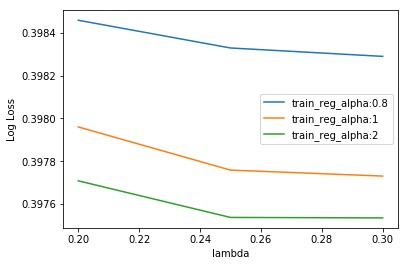

In [80]:
# summarize results
print("Best: %f using %s" % (gsearch2_2.best_score_, gsearch2_2.best_params_))
test_means = gsearch2_2.cv_results_[ 'mean_test_score' ]
test_stds = gsearch2_2.cv_results_[ 'std_test_score' ]
train_means = gsearch2_2.cv_results_[ 'mean_train_score' ]
train_stds = gsearch2_2.cv_results_[ 'std_train_score' ]


pd.DataFrame(gsearch2_2.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(reg_alpha), len(reg_lambda))
train_scores = np.array(train_means).reshape(len(reg_alpha), len(reg_lambda))

for i, value in enumerate(reg_alpha):
#    pyplot.plot(reg_lambda, -test_scores[i], label= 'valid_reg_alpha:'   + str(value))
    pyplot.plot(reg_lambda, -train_scores[i], label= 'train_reg_alpha:'   + str(value))

    
pyplot.legend()
pyplot.xlabel( 'lambda' )                                                                                                      
pyplot.ylabel( 'Log Loss' )
pyplot.savefig('max_depth_vs_min_child_weght_1.png' )

### 3.1单独对叶子节点数目正则系数进行调优

In [36]:
reg_alpha=[0.8,1,2]
param_2=dict(reg_alpha=reg_alpha)
param_2

{'reg_alpha': [0.8, 1, 2]}

In [37]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=3)

params = {'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'nthread': 6, 
          'silent': True,
          'learning_rate': 0.1, 
          'num_leaves': 50, 
          'max_depth': 8,
          'max_bin': 256, 
          'subsample_for_bin': 200000,#默认200000，用来构建直方图数据数量
          'subsample': 0.8, #默认1
          'subsample_freq': 1, 
          'colsample_bytree': 0.8, 
          'reg_alpha': 0,          
          'reg_lambda': 0.25,  
          'min_split_gain': 0.0, 
          'min_child_weight': 1,         
          'min_child_samples': 20, 
          'scale_pos_weight': 1,
         }
lgbm_2=lgbm.sklearn.LGBMClassifier(n_estimators=363,seed=0,**params)
gsearch2_2=GridSearchCV(lgbm_2,param_grid=param_2,scoring='neg_log_loss',n_jobs=6, cv=kfold)
gsearch2_2.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        learning_rate=0.1, max_bin=256, max_depth=8, min_child_samples=20,
        min_child_weight=1, min_split_gain=0.0, n_estimators=363,
        n_jobs=-1, nthread=6, num_leaves=50, objective='binary',
        random_state=None, reg_alpha=0, reg_lambda=0.25,
        scale_pos_weight=1, seed=0, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'reg_alpha': [0.8, 1, 2]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='neg_log_loss',
       verbose=0)

In [38]:
print(gsearch2_2.cv_results_)
print(gsearch2_2.best_score_)
y_pred_train = gsearch2_2.predict_proba(X_train)
logloss = log_loss(y_train, y_pred_train)
print ("logloss of train :",logloss )

y_pred_test = gsearch2_2.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_test)
print ("logloss of test :",logloss )

{'mean_fit_time': array([192.56691368, 210.63699794, 128.29238534]), 'std_fit_time': array([ 0.89683706,  1.19999609, 17.03277942]), 'mean_score_time': array([22.24953945, 40.66610765, 10.79338749]), 'std_score_time': array([0.18408786, 1.11089391, 1.50064434]), 'param_reg_alpha': masked_array(data=[0.8, 1, 2],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'reg_alpha': 0.8}, {'reg_alpha': 1}, {'reg_alpha': 2}], 'split0_test_score': array([-0.39969969, -0.39979197, -0.39975447]), 'split1_test_score': array([-0.39985465, -0.39986001, -0.39987836]), 'split2_test_score': array([-0.39966234, -0.3996646 , -0.399669  ]), 'mean_test_score': array([-0.39973889, -0.39977219, -0.39976728]), 'std_test_score': array([8.32585566e-05, 8.09930858e-05, 8.59488165e-05]), 'rank_test_score': array([1, 3, 2]), 'split0_train_score': array([-0.3975134 , -0.39758671, -0.39761494]), 'split1_train_score': array([-0.3974886 , -0.39750719, -0.39758626]), 's

In [43]:
reg_alpha

[0.8, 1, 2]

In [44]:
test_scores

array([-0.39973889, -0.39977219, -0.39976728])

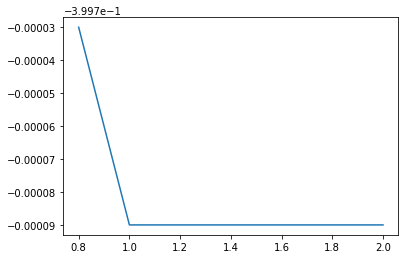

In [77]:
pyplot.plot([0.8, 1, 2],[-0.39973, -0.39979, -0.39979])

Best: -0.399739 using {'reg_alpha': 0.8}


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessin

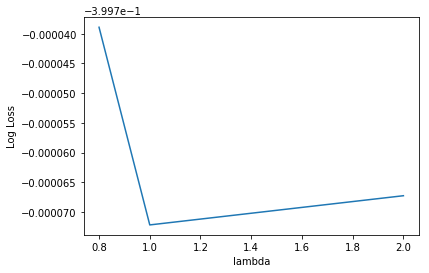

In [46]:
# summarize results
print("Best: %f using %s" % (gsearch2_2.best_score_, gsearch2_2.best_params_))
test_means = gsearch2_2.cv_results_[ 'mean_test_score' ]
test_stds = gsearch2_2.cv_results_[ 'std_test_score' ]
train_means = gsearch2_2.cv_results_[ 'mean_train_score' ]
train_stds = gsearch2_2.cv_results_[ 'std_train_score' ]


pd.DataFrame(gsearch2_2.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_1.csv')

# plot results
test_scores = np.array(test_means)
train_scores = np.array(train_means)


pyplot.plot(reg_alpha, test_scores, label= 'reg_alpha:' )
#    pyplot.plot(reg_lambda, -train_scores[i], label= 'train_reg_alpha:'   + str(value))

    
#pyplot.legend()
pyplot.xlabel( 'lambda' )                                                                                                      
pyplot.ylabel( 'Log Loss' )
pyplot.savefig('max_depth_vs_min_child_weght_1.png' )

### 4、调整行采样和列采样的比例

In [78]:
subsample=[0.4,0.6,0.8]
colsample_bytree=[0.4,0.6,0.8]
param_4=dict(subsample=subsample,colsample_bytree=colsample_bytree)
param_4

{'colsample_bytree': [0.4, 0.6, 0.8], 'subsample': [0.4, 0.6, 0.8]}

In [79]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=3)

params = {'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'nthread': 6, 
          'silent': True,
          'learning_rate': 0.1, 
          'num_leaves': 50, 
          'max_depth': 8,
          'max_bin': 256, 
          'subsample_for_bin': 200000,#默认200000，用来构建直方图数据数量
          'subsample': 0.8, #默认1
          'subsample_freq': 1, 
          'colsample_bytree': 0.8, 
          'reg_alpha': 0.8,          
          'reg_lambda': 0.25,  
          'min_split_gain': 0.0, 
          'min_child_weight': 1,         
          'min_child_samples': 20, 
          'scale_pos_weight': 1,
         }
lgbm_2=lgbm.sklearn.LGBMClassifier(n_estimators=363,seed=0,**params)
gsearch2_2=GridSearchCV(lgbm_2,param_grid=param_4,scoring='neg_log_loss',n_jobs=6, cv=kfold)
gsearch2_2.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        learning_rate=0.1, max_bin=256, max_depth=8, min_child_samples=20,
        min_child_weight=1, min_split_gain=0.0, n_estimators=363,
        n_jobs=-1, nthread=6, num_leaves=50, objective='binary',
        random_state=None, reg_alpha=1, reg_lambda=0.25,
        scale_pos_weight=1, seed=0, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'subsample': [0.4, 0.6, 0.8], 'colsample_bytree': [0.4, 0.6, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [82]:
print(gsearch2_2.cv_results_)
print(gsearch2_2.best_score_)
y_pred_train = gsearch2_2.predict_proba(X_train)
logloss = log_loss(y_train, y_pred_train)
print ("logloss of train :",logloss )

y_pred_test = gsearch2_2.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_test)
print ("logloss of test :",logloss )

{'mean_fit_time': array([180.55394785, 258.98511044, 322.12442772, 235.97703187,
       278.56989423, 292.47091881, 276.41089598, 307.3526427 ,
       218.56975738]), 'std_fit_time': array([29.38156317,  1.31334741, 56.59163823, 27.07649671,  4.13636249,
        8.15903006,  5.15506652,  2.69134724,  9.31214205]), 'mean_score_time': array([17.05652157, 27.34910909, 13.43893059, 16.893068  , 12.68542147,
       13.15065996, 12.9688789 , 10.14399298, 11.82179101]), 'std_score_time': array([3.27383635, 2.09634619, 2.88690092, 3.41404907, 3.74451919,
       4.11921628, 3.32409405, 0.29615581, 3.64243551]), 'param_colsample_bytree': masked_array(data=[0.4, 0.4, 0.4, 0.6, 0.6, 0.6, 0.8, 0.8, 0.8],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_subsample': masked_array(data=[0.4, 0.6, 0.8, 0.4, 0.6, 0.8, 0.4, 0.6, 0.8],
             mask=[False, False, False, False, False, False, Fa

Best: -0.399807 using {'min_child_samples': 20, 'min_child_weight': 2}


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessin

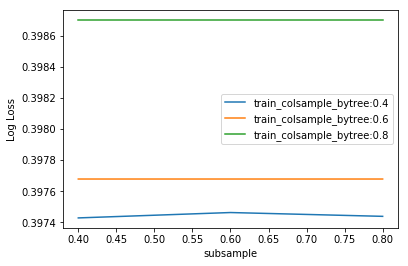

In [94]:
# summarize results
print("Best: %f using %s" % (gsearch2_2.best_score_, gsearch2_2.best_params_))
test_means = gsearch2_2.cv_results_[ 'mean_test_score' ]
test_stds = gsearch2_2.cv_results_[ 'std_test_score' ]
train_means = gsearch2_2.cv_results_[ 'mean_train_score' ]
train_stds = gsearch2_2.cv_results_[ 'std_train_score' ]


pd.DataFrame(gsearch2_2.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(subsample), len(colsample_bytree))
train_scores = np.array(train_means).reshape(len(subsample), len(colsample_bytree))

for i, value in enumerate(subsample):
#    pyplot.plot(colsample_bytree, -test_scores[i], label= 'valid_colsample_bytree:'   + str(value))
    pyplot.plot(subsample, -train_scores[i], label= 'train_colsample_bytree:'   + str(value))

    
pyplot.legend()
pyplot.xlabel( 'subsample' )                                                                                                      
pyplot.ylabel( 'Log Loss' )
pyplot.savefig('max_depth_vs_min_child_weght_1.png' )

### 5、调整叶子节点最小数据量和叶子节点最小权重

In [89]:
min_child_samples=[20,200,2000]
min_child_weight=[0.5,1,2]
param_5=dict(min_child_samples=min_child_samples,min_child_weight=min_child_weight)
param_5

{'min_child_samples': [20, 200, 2000], 'min_child_weight': [0.5, 1, 2]}

In [90]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=3)

params = {'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'nthread': 6, 
          'silent': True,
          'learning_rate': 0.1, 
          'num_leaves': 50, 
          'max_depth': 8,
          'max_bin': 256, 
          'subsample_for_bin': 200000,#默认200000，用来构建直方图数据数量
          'subsample': 0.8, #默认1
          'subsample_freq': 1, 
          'colsample_bytree': 0.8, 
          'reg_alpha': 0.8,          
          'reg_lambda': 0.25,  
          'min_split_gain': 0.0, 
          'min_child_weight': 1,         
          'min_child_samples': 20, 
          'scale_pos_weight': 1,
         }
lgbm_2=lgbm.sklearn.LGBMClassifier(n_estimators=363,seed=0,**params)
gsearch2_2=GridSearchCV(lgbm_2,param_grid=param_5,scoring='neg_log_loss',n_jobs=6, cv=kfold)
gsearch2_2.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        learning_rate=0.1, max_bin=256, max_depth=8, min_child_samples=20,
        min_child_weight=1, min_split_gain=0.0, n_estimators=363,
        n_jobs=-1, nthread=6, num_leaves=50, objective='binary',
        random_state=None, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
        seed=0, silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=1),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'min_child_samples': [20, 200, 2000], 'min_child_weight': [0.5, 1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

Best: -0.399807 using {'min_child_samples': 20, 'min_child_weight': 2}


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessin

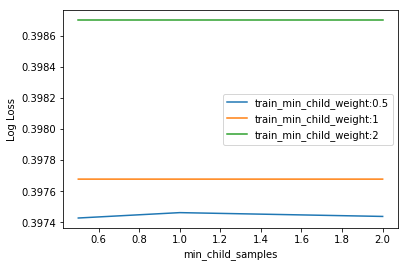

In [99]:
# summarize results
print("Best: %f using %s" % (gsearch2_2.best_score_, gsearch2_2.best_params_))
test_means = gsearch2_2.cv_results_[ 'mean_test_score' ]
test_stds = gsearch2_2.cv_results_[ 'std_test_score' ]
train_means = gsearch2_2.cv_results_[ 'mean_train_score' ]
train_stds = gsearch2_2.cv_results_[ 'std_train_score' ]


pd.DataFrame(gsearch2_2.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(subsample), len(colsample_bytree))
train_scores = np.array(train_means).reshape(len(subsample), len(colsample_bytree))

for i, value in enumerate(min_child_weight):
#    pyplot.plot(min_child_samples, -test_scores[i], label= 'valid_min_child_weight:'   + str(value))
     pyplot.plot(min_child_weight, -train_scores[i], label= 'train_min_child_weight:'   + str(value))

    
pyplot.legend()
pyplot.xlabel( 'min_child_samples' )                                                                                                      
pyplot.ylabel( 'Log Loss' )
pyplot.savefig('max_depth_vs_min_child_weght_1.png' )

### 6 重新优化一下 树的数量

In [100]:
params = {'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'nthread': 6, 
          #default=OpenMP_default, type=int, alias=num_thread, nthread LightGBM 的线程数
          'silent': True,
          'learning_rate': 0.1, 
          'num_leaves': 50, 
          #num_leaves：叶子数
#num_leaves, default=31, type=int, alias=num_leaf一棵树上的叶子数
          'max_depth': 8,
          'max_bin': 256, 
          'subsample_for_bin': 200000,#默认200000，用来构建直方图数据数量
          'subsample': 0.8, #默认1
          #类似于feature_fraction,它将在不进行重采样的情况下
          #随机选择部分数据可以用来加速训练可以用来处理过拟合Not
          'subsample_freq': 1, 
          'colsample_bytree': 0.8,       
          'reg_alpha': 0.8,         
          'reg_lambda': 0.25, 
          'min_split_gain': 0.0, 
          'min_child_weight': 1,        
          'min_child_samples': 100, 
          #default=20, type=int, alias=min_data_per_leaf , min_data, 
          #min_child_samples一个叶子上数据的最小数量. 可以用来处理过拟合.
        

         }

In [101]:
time_start=time.time()

lgbm6 = lgbm.sklearn.LGBMClassifier(n_estimators=1000,seed=0, **params)
modelfit(params,lgbm6, X_train, y_train)

time_end=time.time()
a=time_end - time_start
print('time cost'+str(a)+'s')

C:\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Anaconda3\lib\site-packages\lightgbm\basic.py:661: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


best n_estimators: 284
best cv logloss: 0.39955036588252835
logloss of train : 0.39974860472393803
logloss of test : 0.4045745986483505
time cost232.7710998058319s


### 7模型训练

In [118]:
start=time.time()
# 定义模型
lgb7 = lgbm.LGBMRegressor(
          num_boost_round=284,
          boosting='gbdt', 
          objective='binary', 
          num_threads=6, 
          #default=OpenMP_default, type=int, alias=num_thread, nthread LightGBM 的线程数
#          'silent': True,
          learning_rate=0.1, 
          num_leaves=50, 
          #num_leaves：叶子数
#num_leaves, default=31, type=int, alias=num_leaf一棵树上的叶子数
          max_depth= 8,
          max_bi= 256, 
          subsample_for_bin= 200000,#默认200000，用来构建直方图数据数量
          subsample= 0.8, #默认1
          #类似于feature_fraction,它将在不进行重采样的情况下
          #随机选择部分数据可以用来加速训练可以用来处理过拟合Not
          subsample_freq= 1, 
          colsample_bytree= 0.8,       
          reg_alpha= 0.8,         
          reg_lambda= 0.25, 
          min_split_gain=0.0, 
          min_child_weight= 1,        
          min_child_samples= 200, 
          min_data_in_leaf=50, 
          #default=20, type=int, alias=min_data_per_leaf , min_data, 
          #min_child_samples一个叶子上数据的最小数量. 可以用来处理过拟合.
        
        # 'categorical_feature':3
         # 'categorical_feature':3:26
         )
# 训练学习
model=lgb7.fit(X_train, y_train)
end=time.time()
print(end-start)

C:\Anaconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


92.0268828868866


In [119]:
# train上logloss评测
y_pred_train = lgb7.predict(X_train)
logloss = log_loss(y_train, y_pred_train)
print ("logloss of train :",logloss )

# valid上logloss评测
y_pred_valid = lgb7.predict(X_valid)
logloss = log_loss(y_valid, y_pred_valid)
print ("logloss of valid :",logloss )

# test上logloss评测
y_pred_test = lgb7.predict(X_test)
logloss = log_loss(y_test, y_pred_test)
print ("logloss of test :",logloss )

logloss of train : 0.4001760588598642
logloss of valid : 0.40093575026031686
logloss of test : 0.40354506207393454
